In [1]:
from utilities import init_bigquery_client
from google.cloud import bigquery
import os
import pandas as pd
import numpy as np
import plotly.express as px

from plotnine import *

#init BigQuery client
bq = init_bigquery_client()

Using BigQuery credentials: etl-testing-478716-c0b6c2c512e0.json


## Perform bulk queries

In [2]:
# Read from the 'events' table in BigQuery
query = """
    SELECT *
    FROM `etl-testing-478716.firebase_etl_prod.events`
"""
events_df = bq.query(query).to_dataframe()

# Read from the 'userinvites' table in BigQuery
query = """
    SELECT *
    FROM `etl-testing-478716.firebase_etl_prod.userinvites`
"""
userinvites_df = bq.query(query).to_dataframe()

# Read from the 'users' table in BigQuery
query = """
    SELECT *
    FROM `etl-testing-478716.firebase_etl_prod.users`
"""
users_df = bq.query(query).to_dataframe()

/opt/miniconda3/envs/heyyall/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.


## Number of Events Created Per Day with Invites

In [3]:
#filtering out duplicate events to get most recent edit
events_df = events_df.sort_values('createdAt', ascending=False).drop_duplicates(subset=['document_id'], keep='first')

In [4]:
# Merge events with userinvites on event ID
events_w_invites = events_df.merge(userinvites_df, left_on='document_id', right_on='event_id', how='left', suffixes=('_event', '_invite'))
#df num events created per day that have invites
unique_events_per_day = (
    events_w_invites
    .dropna(subset=['document_id_invite'])
    .groupby(pd.Grouper(key='createdAt_event', freq='D'))['document_id_event']
    .nunique()
    .reset_index(name='unique_event_count')
)

In [5]:
#Graph number of events created per day with invites
fig = px.bar(unique_events_per_day, x='createdAt_event', y='unique_event_count', title='Number of Events Created Per Day with Invites')
fig.show()

## Attendees Per Event

In [6]:
#Getting count of each RSVP status per event
count_rsvp = events_w_invites.groupby(['document_id_event', 'status']).size().reset_index(name='count').pivot(index='document_id_event', columns='status', values='count').fillna(0)
#merge with events to get event details
count_rsvp = count_rsvp.merge(events_df, left_on='document_id_event', right_on='document_id', how='left')

In [7]:
#Plotting number of accepted invites per event by type
count_rsvp['createdAt_date'] = count_rsvp['createdAt'].dt.date
px.bar(count_rsvp[count_rsvp['type'] != 'checkin'], x='createdAt_date', y='accepted', color='type', title='Number of Accepted Invites per Event by Type').show()

In [8]:
#Total accepted invites by event type pie chart in last 30 days
x_days_ago_date = (pd.Timestamp.now() - pd.Timedelta(days=30)).tz_localize('UTC')

percent_invite_by_type = count_rsvp[count_rsvp['createdAt'] >= x_days_ago_date].groupby('type')['accepted'].sum().reset_index(name='sum_accepted_invites')
percent_invite_by_type = percent_invite_by_type[percent_invite_by_type['type'] != 'checkin']
percent_invite_by_type['percentage'] = (percent_invite_by_type['sum_accepted_invites'] / percent_invite_by_type['sum_accepted_invites'].sum()) * 100
fig = px.pie(percent_invite_by_type, names='type', values='percentage', width=550, height=400)
fig.update_layout(
    title={
        'text': "% of Accepted Invites by Event Type in Last 30 Days",
        'y': 0.92,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)
fig.show()


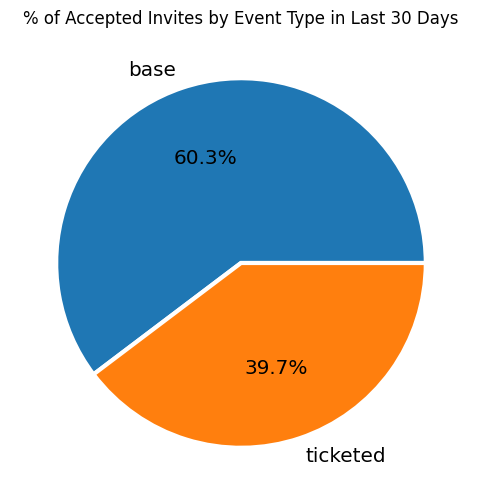

In [9]:
# Create the pie chart
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(x=percent_invite_by_type['percentage'], labels=percent_invite_by_type['type'], autopct='%.1f%%', 
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})
ax.set_title('% of Accepted Invites by Event Type in Last 30 Days')
plt.show()

In [10]:
import pytz

# Make the comparison timestamp timezone-aware (UTC)
#average acceptance per event current period and previous period 
now_utc = pd.Timestamp.now(tz='UTC')
two_weeks_ago = now_utc - pd.Timedelta(weeks=2)
four_weeks_ago = now_utc - pd.Timedelta(weeks=4)

avg_acceptance_current = count_rsvp[count_rsvp['createdAt'] >= two_weeks_ago]['accepted'].mean()
avg_acceptance_previous = count_rsvp[(count_rsvp['createdAt'] < two_weeks_ago) & (count_rsvp['createdAt'] >= four_weeks_ago)]['accepted'].mean()
import plotly.graph_objects as go

# Get the accepted invite counts for the two periods
recent_value = avg_acceptance_current if avg_acceptance_current is not None else 0
prior_value = avg_acceptance_previous if avg_acceptance_previous is not None else 0

fig = go.Figure(go.Indicator(
    mode = "number+delta",
    value = recent_value,
    delta = {'reference': prior_value, 'relative': False},
    title = {'text': "Average Accepted Invites per Event (Last 2 Weeks)"},
    gauge = {'shape': "bullet"}
))

fig.update_layout(
    grid = {'rows': 1, 'columns': 1, 'pattern': "independent"},
    template = {'data' : {'indicator': [{
        'title': {'text': "Average Accepted Invites per Event"},
        'mode' : "number+delta",
        'delta' : {'reference': prior_value}}]
    }}
)

fig.show()

In [11]:
# Ratio of accepted vs total invited
count_rsvp['ratio_invites'] = count_rsvp['accepted'] / (count_rsvp[['accepted', 'invited', 'rejected']].sum(axis=1) + 1)  # Adding 1 to avoid division by zero

#Difficult to show in a compelling way


## Time to First Event

Users without createdAt is 125, this number should not go up now that we fixed the createdAt info

In [12]:
#filtering to users with createdAt
filtered_users_df = users_df[~users_df['createdAt'].isnull()]

In [17]:
#join filtered users with events
first_planned_event = filtered_users_df.merge(events_df.sort_values('createdAt', ascending=True).drop_duplicates(subset='user_id', keep='first'),
                         on='user_id',
                             how='left',
                             suffixes=('_user', '_event'))
#time to first Event Creation
first_planned_event['time_to_first_event'] = (first_planned_event['createdAt_event'] - first_planned_event['createdAt_user']).dt.days

/opt/miniconda3/envs/heyyall/lib/python3.13/site-packages/plotnine/layer.py:293: PlotnineWarning:

stat_ydensity : Removed 177 rows containing non-finite values.

/opt/miniconda3/envs/heyyall/lib/python3.13/site-packages/plotnine/layer.py:374: PlotnineWarning:

geom_point : Removed 177 rows containing missing values.



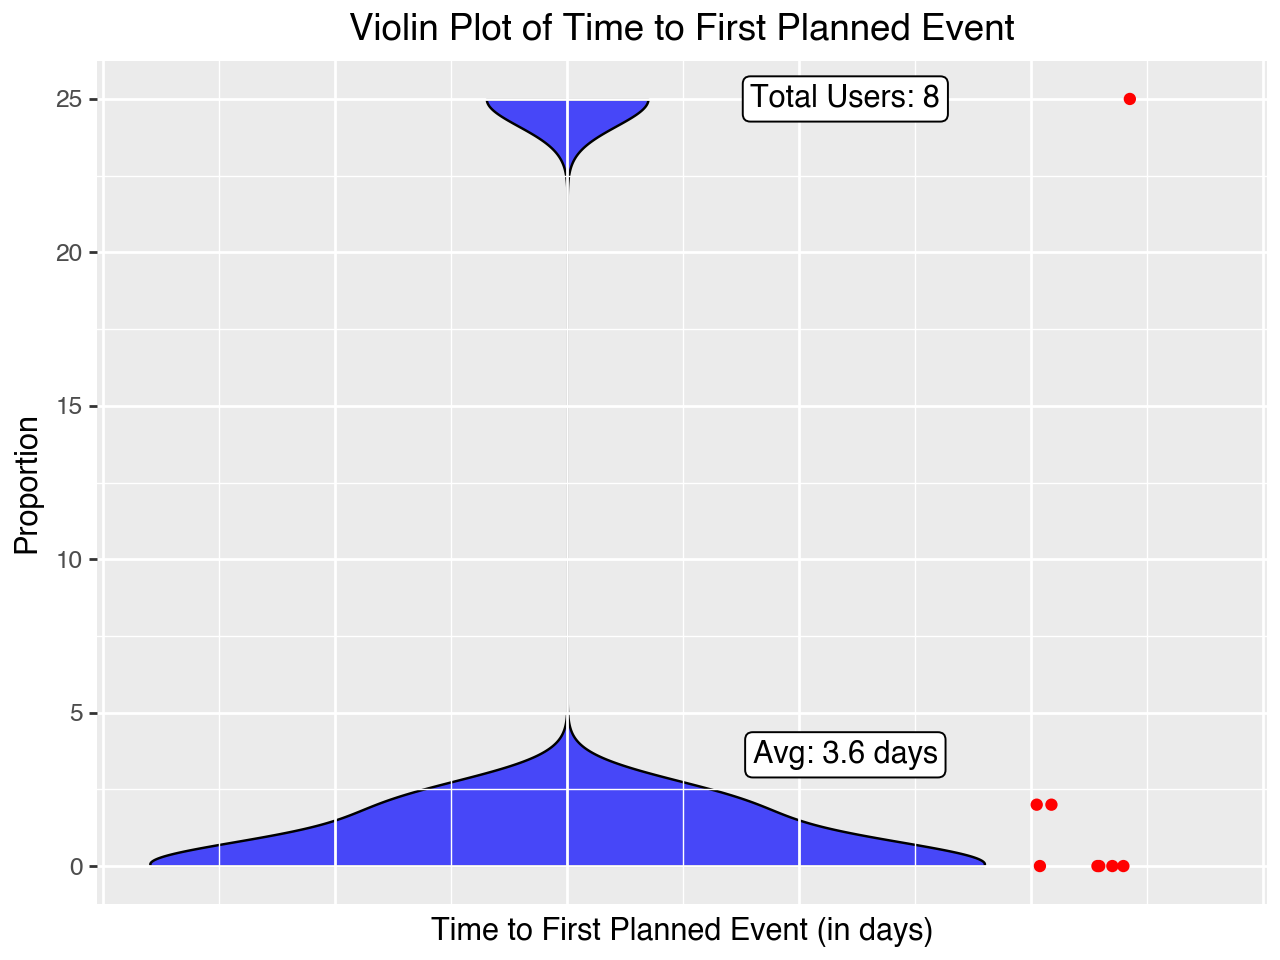

In [18]:
from plotnine import *

avg = first_planned_event['time_to_first_event'].mean()
total = first_planned_event[first_planned_event['time_to_first_event'].notnull()].shape[0]

labels_df = pd.DataFrame({
    'x': [0.3, 0.3],
    'y': [avg, first_planned_event['time_to_first_event'].max()],
    'label': [f'Avg: {avg:.1f} days', f'Total Users: {total}']
})

#used for point plotting
first_planned_event['x_jitter'] = 0.5 + np.random.uniform(0.0, 0.2, size=first_planned_event.shape[0])

event_create_violin = (ggplot(first_planned_event, aes(y='time_to_first_event')) +
    geom_violin(fill='blue', color='black', alpha=0.7) +
    geom_point(aes(x='x_jitter', y='time_to_first_event'), color='red') +
    labs(title='Violin Plot of Time to First Planned Event', x='Time to First Planned Event (in days)', y = "Proportion") +
    theme(axis_text_x=element_blank(), # Removes the tick labels
        axis_ticks_x=element_blank(), # Removes the tick marks
    ) +
    geom_label(data=labels_df, 
               mapping=aes(x='x', y='y', label='label'),
                inherit_aes=False)
)

event_create_violin.show()

/opt/miniconda3/envs/heyyall/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10

/opt/miniconda3/envs/heyyall/lib/python3.13/site-packages/plotnine/layer.py:293: PlotnineWarning:

stat_ydensity : Removed 177 rows containing non-finite values.

/opt/miniconda3/envs/heyyall/lib/python3.13/site-packages/plotnine/layer.py:374: PlotnineWarning:

geom_point : Removed 29 rows containing missing values.



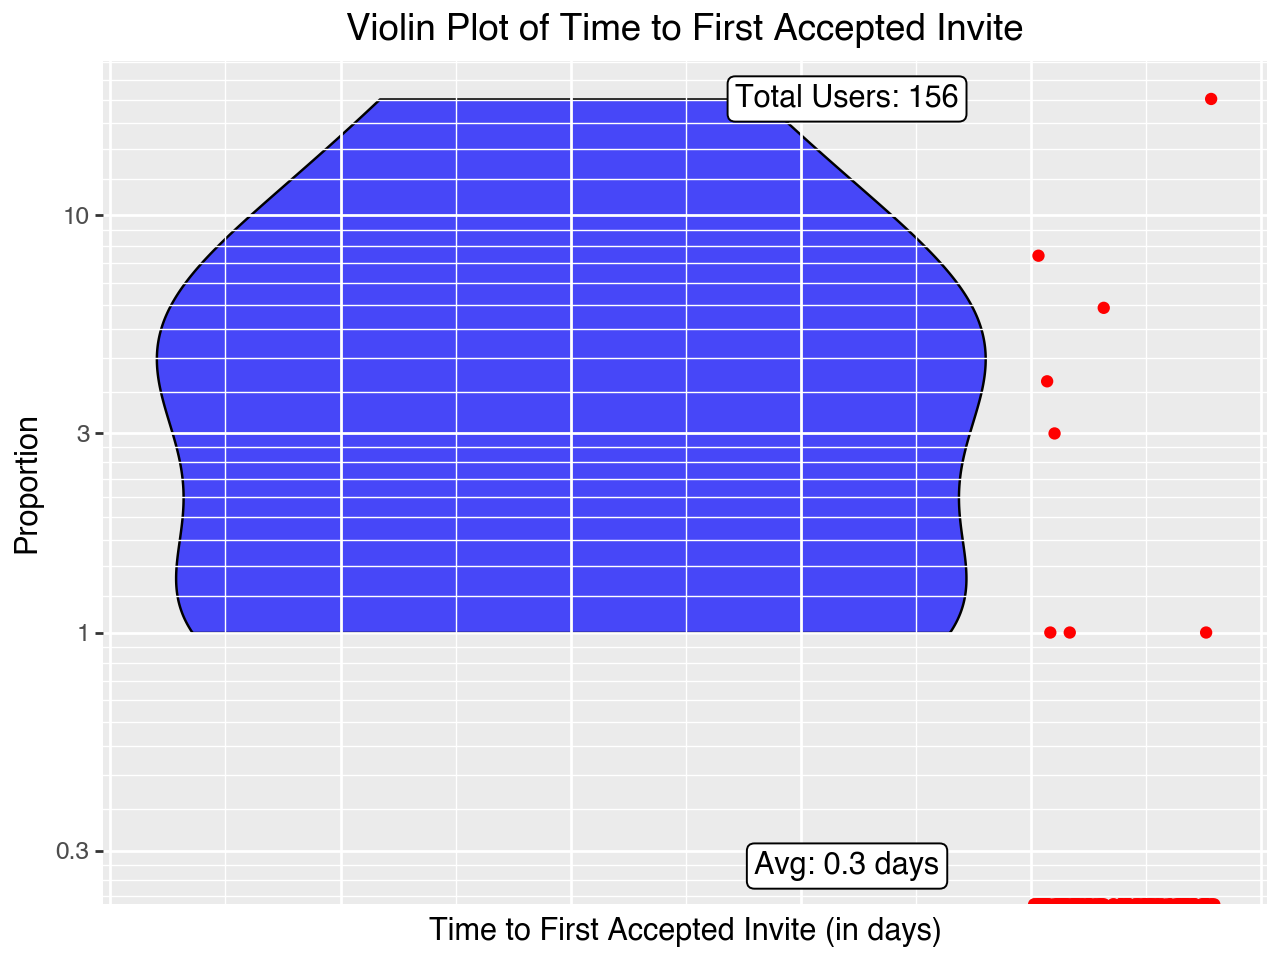

In [19]:
#time to first event acceptance
#join filtered users with invites
first_accepted_invite = filtered_users_df.merge(userinvites_df.sort_values('createdAt', ascending=True).drop_duplicates(subset='user_id', keep='first'),
                         on='user_id',
                             how='left',
                             suffixes=('_user', '_invite'))

first_accepted_invite['time_to_first_accepted_invite'] = (first_accepted_invite['createdAt_invite'] - first_accepted_invite['createdAt_user']).dt.days

#first accepted invite graph
avg = first_accepted_invite['time_to_first_accepted_invite'].mean()
total = first_accepted_invite[first_accepted_invite['time_to_first_accepted_invite'].notnull()].shape[0]

labels_df = pd.DataFrame({
    'x': [0.3, 0.3],
    'y': [avg, first_accepted_invite['time_to_first_accepted_invite'].max()],
    'label': [f'Avg: {avg:.1f} days', f'Total Users: {total}']
})

#used for point plotting
first_accepted_invite['x_jitter'] = 0.5 + np.random.uniform(0.0, 0.2, size=first_accepted_invite.shape[0])

joiners_violin = (ggplot(first_accepted_invite, aes(y='time_to_first_accepted_invite')) +
    geom_violin(fill='blue', color='black', alpha=0.7) +
    geom_point(aes(x='x_jitter', y='time_to_first_accepted_invite'), color='red') +
    labs(title='Violin Plot of Time to First Accepted Invite', x='Time to First Accepted Invite (in days)', y = "Proportion") +
    theme(axis_text_x=element_blank(), # Removes the tick labels
        axis_ticks_x=element_blank(), # Removes the tick marks
    ) +
    geom_label(data=labels_df, 
               mapping=aes(x='x', y='y', label='label'),
                inherit_aes=False) +
    scale_y_log10()
)

joiners_violin.show()

## Repeat Event Creators

Getting how many and what type of event users are planning in the app

In [20]:
#creating table of planned events by user and type
events_per_user = events_df.groupby(['user_id','type']).document_id.count().reset_index().pivot(index='user_id', columns='type', values='document_id').fillna(0)
#merging on user information
events_per_user = events_per_user.merge(users_df[['user_id','createdAt', 'username', 'fullName']],
                       left_on='user_id',
                         right_on='user_id',
                           how='left').fillna({'username': 'deleted', 'fullName': 'deleted'})

events_per_user['total_events'] = events_per_user[['base','checkin','fundraising', 'ticketed']].sum(axis=1)

In [21]:
#Number of repeat planners
events_per_user[events_per_user['total_events'] > 1]

,user_id,base,checkin,fundraising,ticketed,createdAt,username,fullName,total_events
1,0PNBuWC4P5by27fmCRYtT89Jdtl1,3.0,5.0,0.0,0.0,NaT,traskyall,trask dix,8.0
2,3dedM4sg6xZVoCDDkM5WWgDGhLd2,8.0,7.0,0.0,0.0,NaT,brandonquick,Brandon Quick,15.0
3,3jLVl2kE7if51uOdlojTMLDkPoG3,2.0,0.0,0.0,0.0,NaT,deleted,deleted,2.0
5,7QiegKPyi1fArNWHTstwm8WjPct1,2.0,2.0,0.0,0.0,NaT,jenniferpyle,Jennifer Pyle,4.0
7,8SGMqkCelsT88n2qU61lWhFWIrA3,1.0,0.0,4.0,3.0,2025-11-14 22:41:27.564000+00:00,captainflapjacks,Captain Flapjacks,8.0
8,9gHK6nfBJrVyx1543vFgvOKL85N2,1.0,2.0,0.0,0.0,NaT,dane,Dane Iliff,3.0
10,HMNMQxE4ZlOqFietyb4bnTSHZEv2,2.0,0.0,0.0,0.0,NaT,dannykopack,Danny Kopack,2.0
12,PlJR3clMj8QQwTXwsfGGclxGNFE3,0.0,1.0,1.0,0.0,2025-11-18 20:08:56.484000+00:00,yallevents,YALL,2.0
13,QFxHzayNZSRyDcrLAPJf5Oi9dY42,28.0,12.0,0.0,0.0,NaT,zachgiberson,Zach Giberson,40.0
15,c1honNlJLbcoOpOppL2eRKObG9u1,2.0,0.0,0.0,0.0,NaT,jack,Jack Churchill,2.0


## Event Planning over Week

Creating a graph to show number of events created per week, and show the number of active users (basically unique users who created events)

In [22]:
# Group by date and count events
events_per_week = events_df[events_df['type']!='checkin'].resample('W', on='createdAt').size().reset_index(name='events_created')

#Calculate weekly uniquer planner counts
unique_planners_per_week = events_df.groupby(pd.Grouper(key='createdAt', freq='W'))['user_id'].nunique().reset_index(name='unique_planners')
# Filter to last 90 days
import datetime as datetime
days_90 = pd.Timestamp.now(tz='UTC') - pd.Timedelta(days=90)

events_per_week = events_per_week[events_per_week['createdAt'] >= days_90]
unique_planners_per_week = unique_planners_per_week[unique_planners_per_week['createdAt'] >= days_90]

In [ ]:
events_per_week

In [26]:
unique_planners_per_week.head()

,createdAt,unique_planners
0,2025-11-16 00:00:00+00:00,3
1,2025-11-23 00:00:00+00:00,13
2,2025-11-30 00:00:00+00:00,7
3,2025-12-07 00:00:00+00:00,4
4,2025-12-14 00:00:00+00:00,5


In [31]:
from plotnine import *

# Highlight range for last 2 weeks
highlight_start = pd.Timestamp.now(tz='UTC') - pd.Timedelta(days=14)
highlight_end = events_per_week['createdAt'].max()

# Create a column to indicate highlight
highlight_mask = events_per_week['createdAt'].between(highlight_start, highlight_end)
events_per_week['highlight'] = highlight_mask.astype(int)

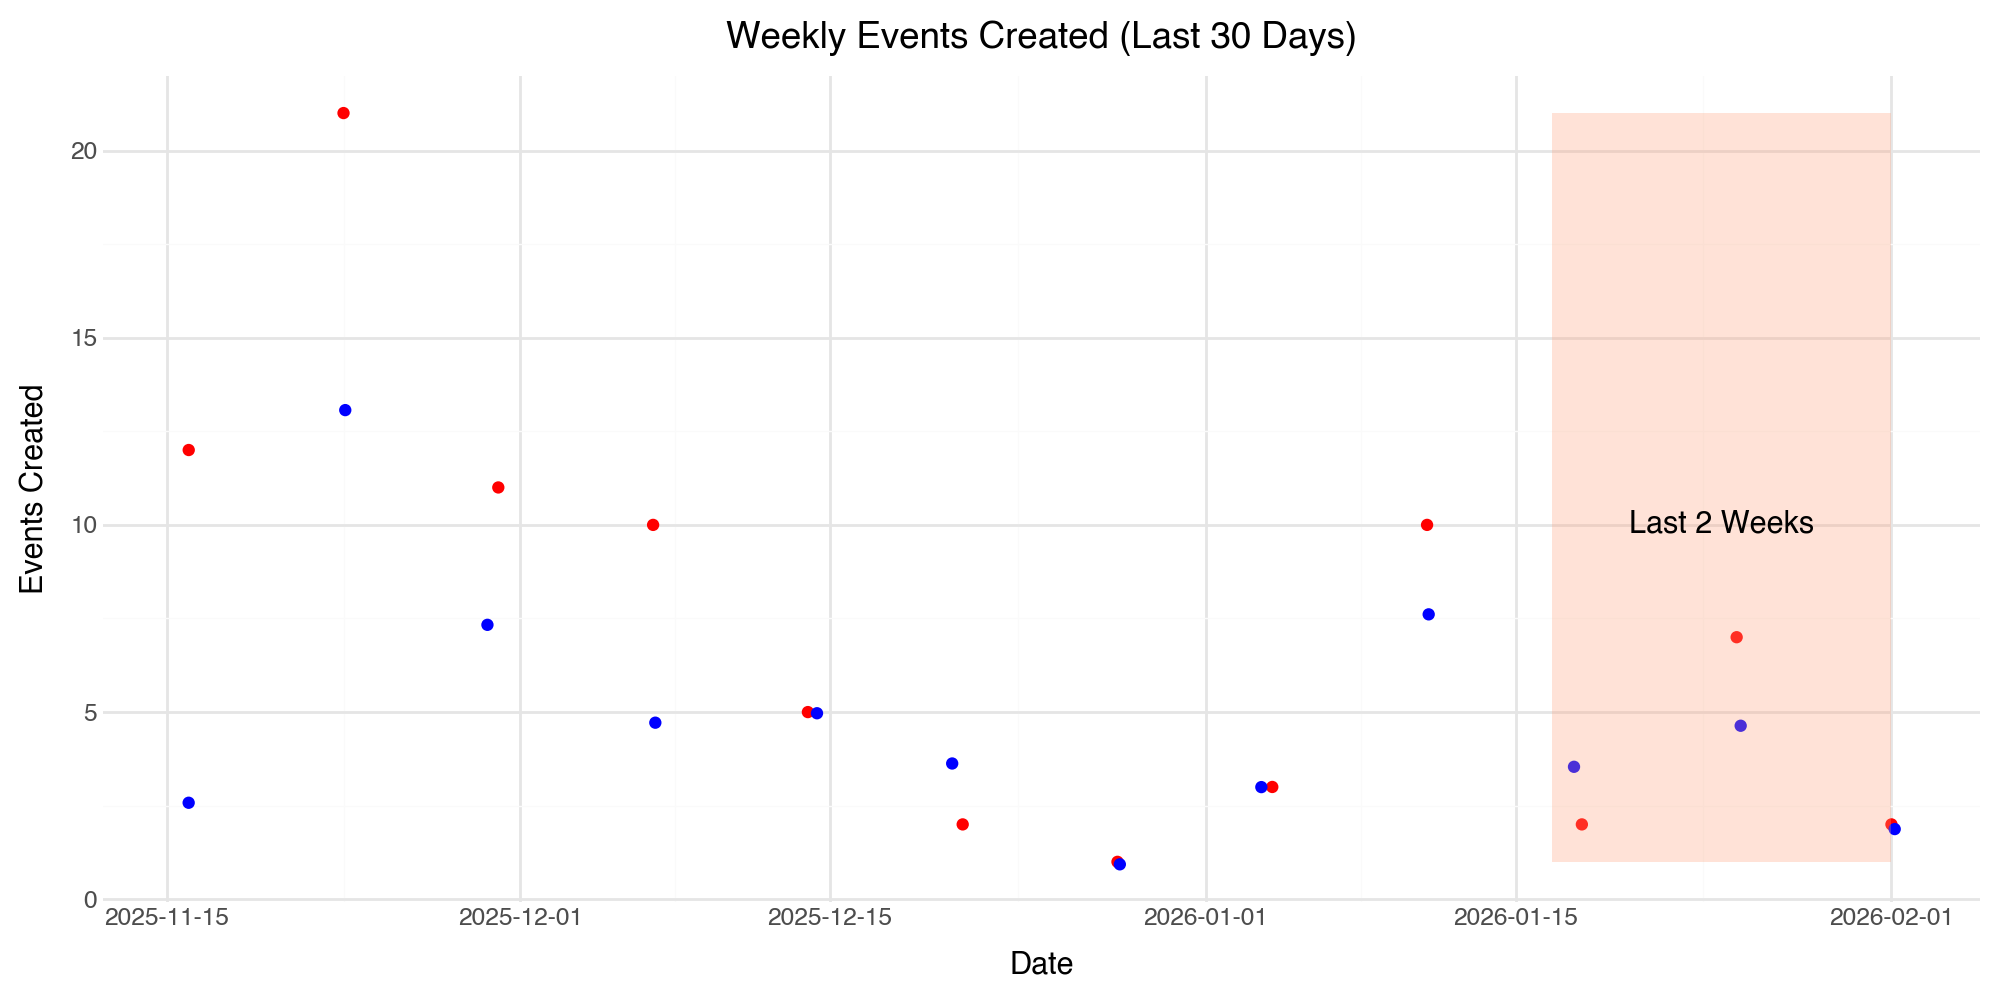

In [ ]:
# Plot with plotnine
event_velocity_plot = (
    ggplot() +
    geom_point(
        data=graph_df,
        mapping=aes(x='createdAt', y='events_created', shape='"Events Created"'),
        color='red',
        show_legend=True
    ) +
    geom_point(
        data=graph_df,
        mapping=aes(x='createdAt', y='unique_planners', shape='"Unique Planners"'),
        color='blue',
        position=position_jitter(height=0.8, width=0.5),
        show_legend=True
    ) +
    scale_shape_manual(values={"Events Created": "o", "Unique Planners": "s"}) +
    labs(
        title='Weekly Events Created (Last 30 Days)',
        x='Date',
        y='Events Created',
        shape='Legend'
    ) +
    geom_rect(
        data=highlight_df,
        mapping=aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax'),
        fill='lightsalmon', alpha=0.3, inherit_aes=False
    ) +
    theme_minimal() +
    theme(figure_size=(10, 5)) +
    geom_text(
        data=labels_df,
        mapping=aes(x='x', y='y', label='label'),
        inherit_aes=False
    )
)

event_velocity_plot.show()

## Event Creation/Date times

When do users create events? like when do they typically start planning 
When are events actually planned for what day and time ?